## Robust Kalman Filtering

Using robust kalman filtering to handle non-gaussian input data for improved state estimation

## Setup

In [18]:
!python3 -m pip install -r ../../requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## Data Generation

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def plot_state(t,actual, estimated=None):
    '''
    plot position, speed, and acceleration in the x and y coordinates for
    the actual data, and optionally for the estimated data
    '''
    trajectories = [actual]
    if estimated is not None:
        trajectories.append(estimated)

    fig, ax = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(8,8))
    for x, w in trajectories:
        ax[0,0].plot(t,x[0,:-1])
        ax[0,1].plot(t,x[1,:-1])
        ax[1,0].plot(t,x[2,:-1])
        ax[1,1].plot(t,x[3,:-1])
        ax[2,0].plot(t,w[0,:])
        ax[2,1].plot(t,w[1,:])

    ax[0,0].set_ylabel('x position')
    ax[1,0].set_ylabel('x velocity')
    ax[2,0].set_ylabel('x input')

    ax[0,1].set_ylabel('y position')
    ax[1,1].set_ylabel('y velocity')
    ax[2,1].set_ylabel('y input')

    ax[0,1].yaxis.tick_right()
    ax[1,1].yaxis.tick_right()
    ax[2,1].yaxis.tick_right()

    ax[0,1].yaxis.set_label_position("right")
    ax[1,1].yaxis.set_label_position("right")
    ax[2,1].yaxis.set_label_position("right")

    ax[2,0].set_xlabel('time')
    ax[2,1].set_xlabel('time')

def plot_positions(traj, labels, axis=None,filename=None):
    '''
    show point clouds for true, observed, and recovered positions
    '''
    matplotlib.rcParams.update({'font.size': 14})
    n = len(traj)

    fig, ax = plt.subplots(1, n, sharex=True, sharey=True,figsize=(12, 5))
    if n == 1:
        ax = [ax]

    for i,x in enumerate(traj):
        ax[i].plot(x[0,:], x[1,:], 'ro', alpha=.1)
        ax[i].set_title(labels[i])
        if axis:
            ax[i].axis(axis)

    if filename:
        fig.savefig(filename, bbox_inches='tight')

In [20]:
n = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts, delt = np.linspace(0,T,n,endpoint=True, retstep=True)
gamma = .05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))
C = np.zeros((2,4))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt

C[0,0] = 1
C[1,1] = 1

## Run Simulation

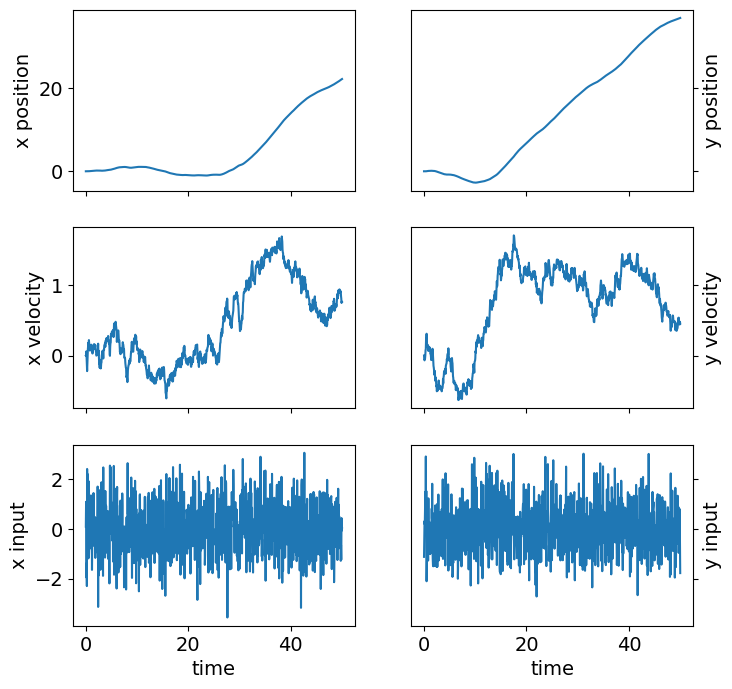

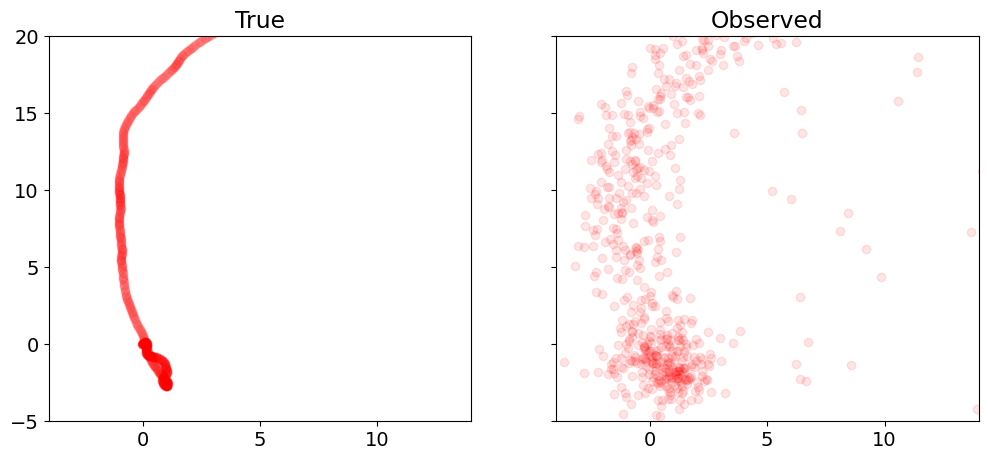

In [21]:
sigma = 20
p = .20
np.random.seed(8)

x = np.zeros((4,n+1))
x[:,0] = [0,0,0,0]
y = np.zeros((2,n))

# generate random input and noise vectors
w = np.random.randn(2,n)
v = np.random.randn(2,n)

# add outliers to v
np.random.seed(0)
inds = np.random.rand(n) <= p
v[:,inds] = sigma*np.random.randn(2,n)[:,inds]

# simulate the system forward in time
for t in range(n):
    y[:,t] = C.dot(x[:,t]) + v[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])

x_true = x.copy()
w_true = w.copy()

plot_state(ts,(x_true,w_true))
plot_positions([x_true,y], ['True', 'Observed'],[-4,14,-5,20],'plots/simulation.pdf')

## Robust Kalman Filter Reconstruction

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Aug 25 02:17:40 AM: Your problem has 8004 variables, 2000 constraints, and 0 parameters.
(CVXPY) Aug 25 02:17:40 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 25 02:17:40 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 25 02:17:40 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 25 02:17:41 AM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 25 02:17:41 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

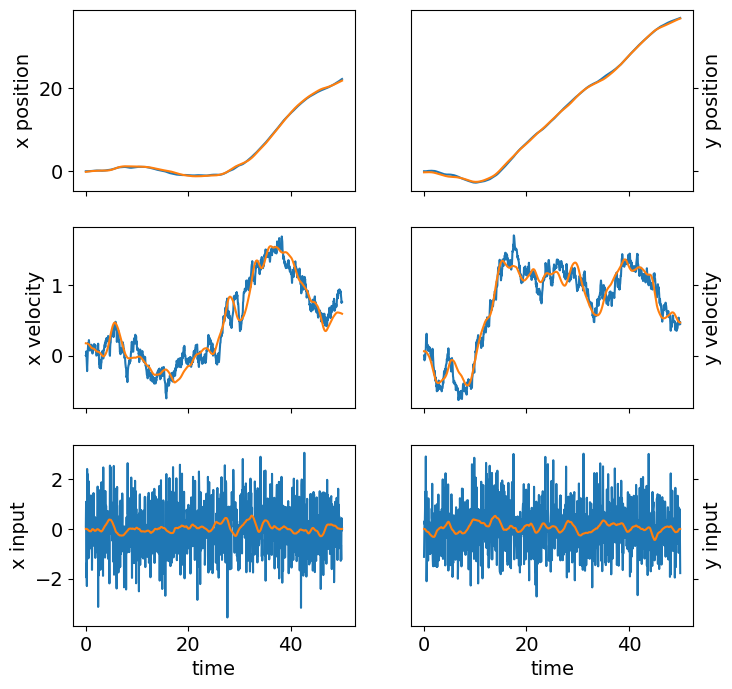

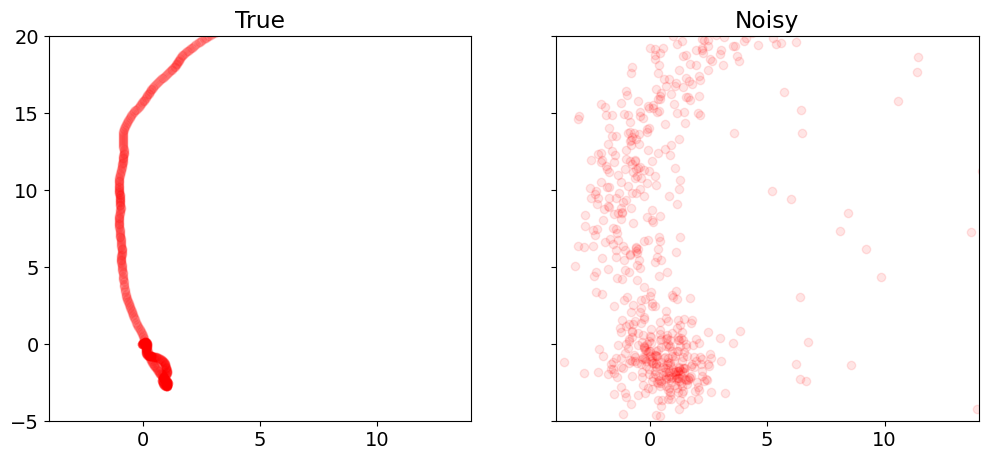

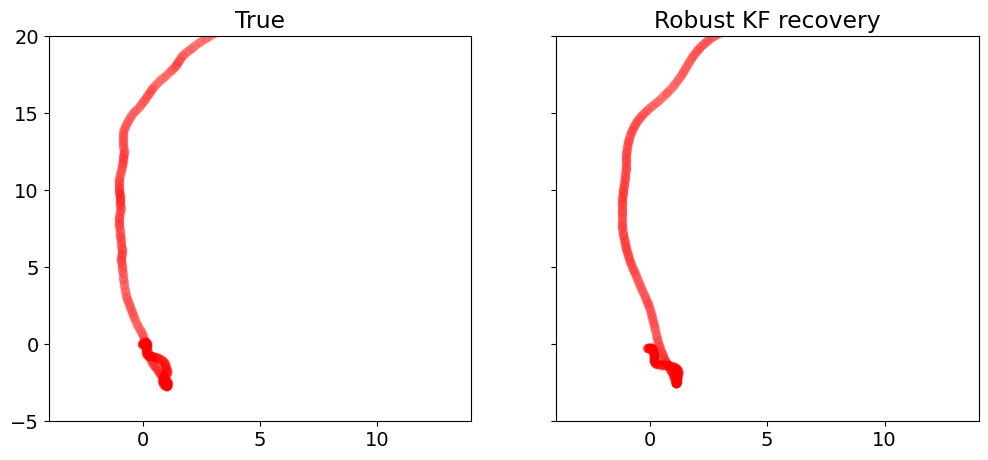

In [22]:
%%time
import cvxpy as cp
import warnings

x = cp.Variable(shape=(4, n+1))
w = cp.Variable(shape=(2, n))
v = cp.Variable(shape=(2, n))

tau = 2
rho = 2

obj = cp.sum_squares(w)
obj += cp.sum([tau*cp.huber(cp.norm(v[:,t]),rho) for t in range(n)])
obj = cp.Minimize(obj)

constr = []
for t in range(n):
    constr += [ x[:,t+1] == A*x[:,t] + B*w[:,t] ,
                y[:,t]   == C*x[:,t] + v[:,t]   ]

cp.Problem(obj, constr).solve(verbose=True)

x = np.array(x.value)
w = np.array(w.value)

plot_state(ts,(x_true,w_true),(x,w))
plot_positions([x_true,y], ['True', 'Noisy'], [-4,14,-5,20])
plot_positions([x_true,x], ['True', 'Robust KF recovery'], [-4,14,-5,20],'plots/reconstruction.pdf')

warnings.filterwarnings('ignore')
print("optimal objective value: {}".format(obj.value))